In [1]:
from brpylib import NsxFile
import os
import numpy as np
import matplotlib.pyplot as plt

import direct_neural_biasing as dnb

## read data

In [2]:
data_file = np.load('data/Patient2EEG.npy')
mrk_file = 'data/Patient02_OfflineMrk.mrk'
data = data_file[0]

In [3]:
np.shape(data)

(83220000,)

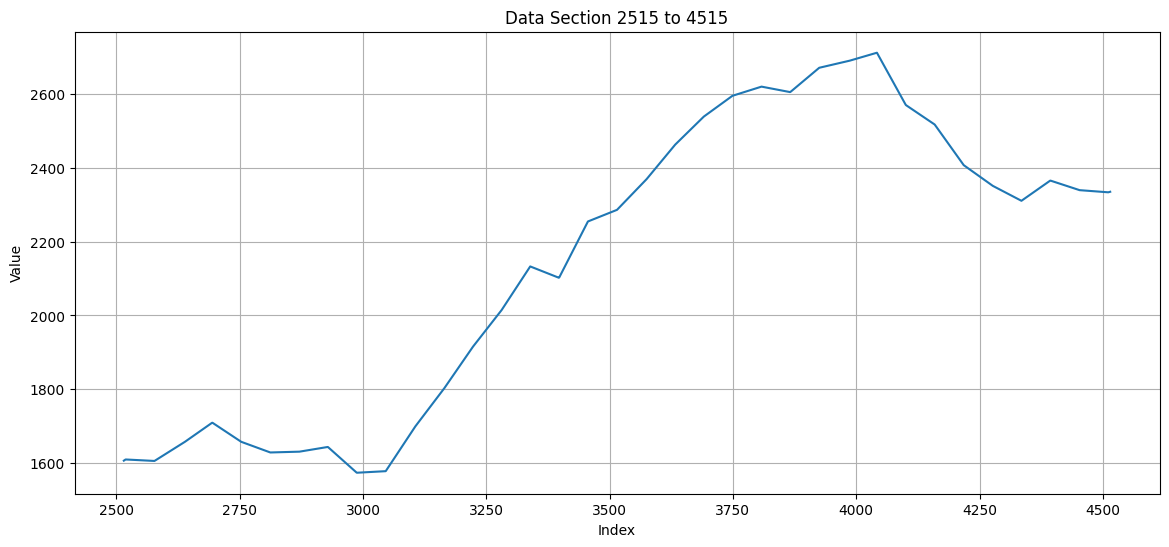

In [4]:
def plot_data_stream_section(data_stream, n, m):
    """
    Plots an n-m section of a 1D integer data stream as a line graph.

    Args:
        data_stream (list or numpy.ndarray): The 1D integer data stream.
        n (int): The starting index (inclusive).
        m (int): The ending index (inclusive).
    """
    section = data_stream[n : m + 1]
    indices = range(n, m + 1)

    plt.figure(figsize=(14, 6))
    plt.plot(indices, section)
    plt.title(f'Data Section {n} to {m}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

start_t = 2515
end_t = 4515

plot_data_stream_section(data, start_t, end_t)

In [5]:
# --- Concise .mrk file parser ---
def parse_mrk_file_concise(filepath):
    """
    Parses a .mrk file into a dictionary (signal_type: [indices]).
    Assumes first line is header, subsequent lines are 'index index signal_type'.
    """
    mrk_data = {}
    with open(filepath, 'r') as f:
        next(f) # Skip header line
        for line in f:
            parts = line.strip().split()
            if len(parts) == 3:
                index = int(parts[0])
                signal_type = parts[2]
                mrk_data.setdefault(signal_type, []).append(index)
    return mrk_data

def plot_marker_with_context(data_stream, marker_index, signal_type, context_window=500, output_dir="marker_plots"):
    """
    Plots a single marker with surrounding data context.
    """
    marker_index = int((marker_index / 512) * 30000) # adjust for differe3nces in sample rate
    data_length = len(data_stream)
    plot_start = max(0, marker_index - context_window)
    plot_end = min(data_length - 1, marker_index + context_window)

    section_data = data_stream[plot_start : plot_end + 1]
    section_indices = range(plot_start, plot_end + 1)

    # CORRECTED LINE: Check if the section_data is empty using its length/size
    if len(section_data) == 0: # or if section_data.size == 0: if you're sure it's a numpy array
        print(f"Skipping plot for marker {marker_index} ({signal_type}) due to empty data section.")
        return

    plt.figure(figsize=(14, 6))
    plt.plot(section_indices, section_data, label='Continuous Data', color='blue', linewidth=1.5)

    # Highlight the marker point
    plt.axvline(x=marker_index, color='red', linestyle='--', label=f'Marker: {signal_type}')
    # Ensure the marker_index is within the bounds of data_stream before trying to access it
    if 0 <= marker_index < data_length:
        plt.plot(marker_index, data_stream[marker_index], 'ro', markersize=8, label='Marker Location')
    else:
        print(f"Warning: Marker index {marker_index} is out of bounds for data_stream. Cannot plot marker point.")


    plt.title(f'Signal Type: {signal_type} at Index: {marker_index} (Context: $\pm${context_window})')
    plt.xlabel('Data Index')
    plt.ylabel('Value')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    
    plt.show()
    plt.close()


Parsed Markers:
  offlineSW: [3515, 7210, 7897, 14431, 16326]... (208 total)

Generating and displaying the first 5 plots with context window of $\pm$100000...


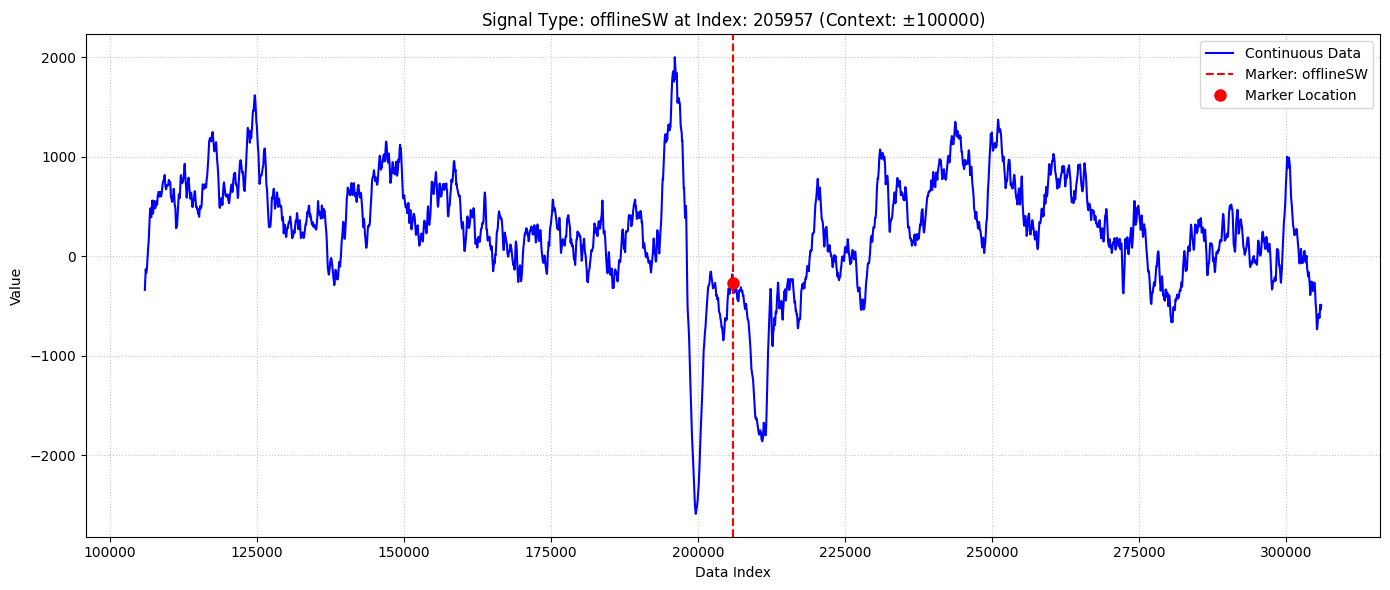

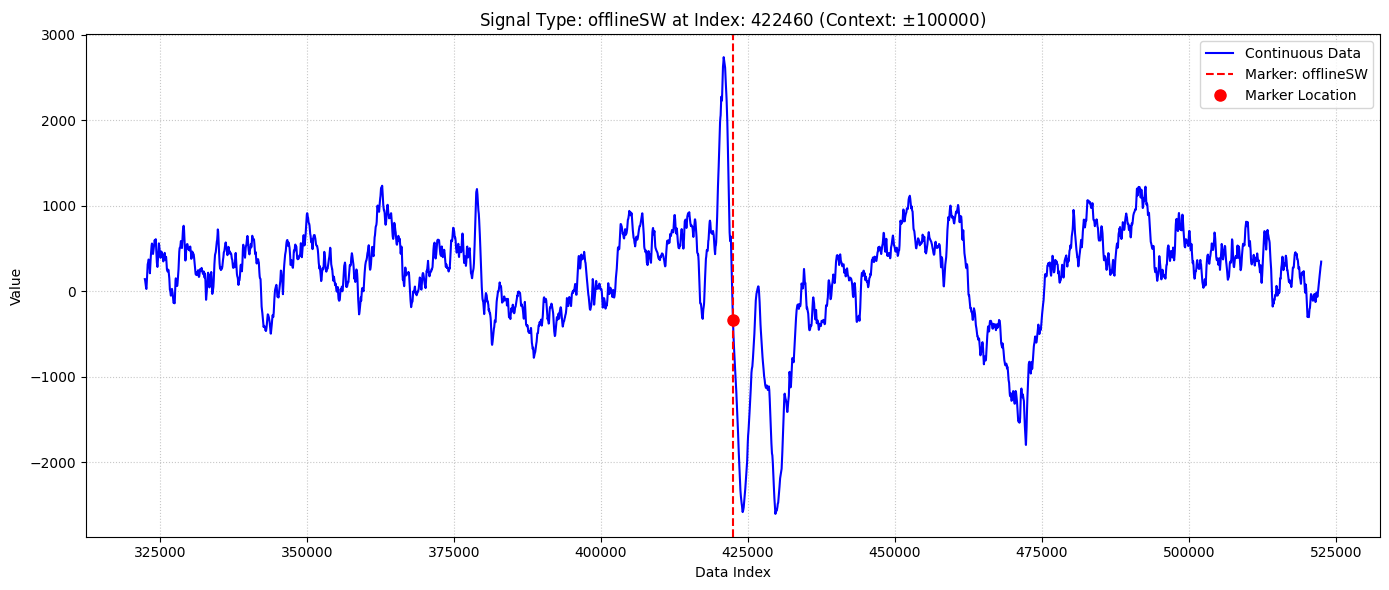

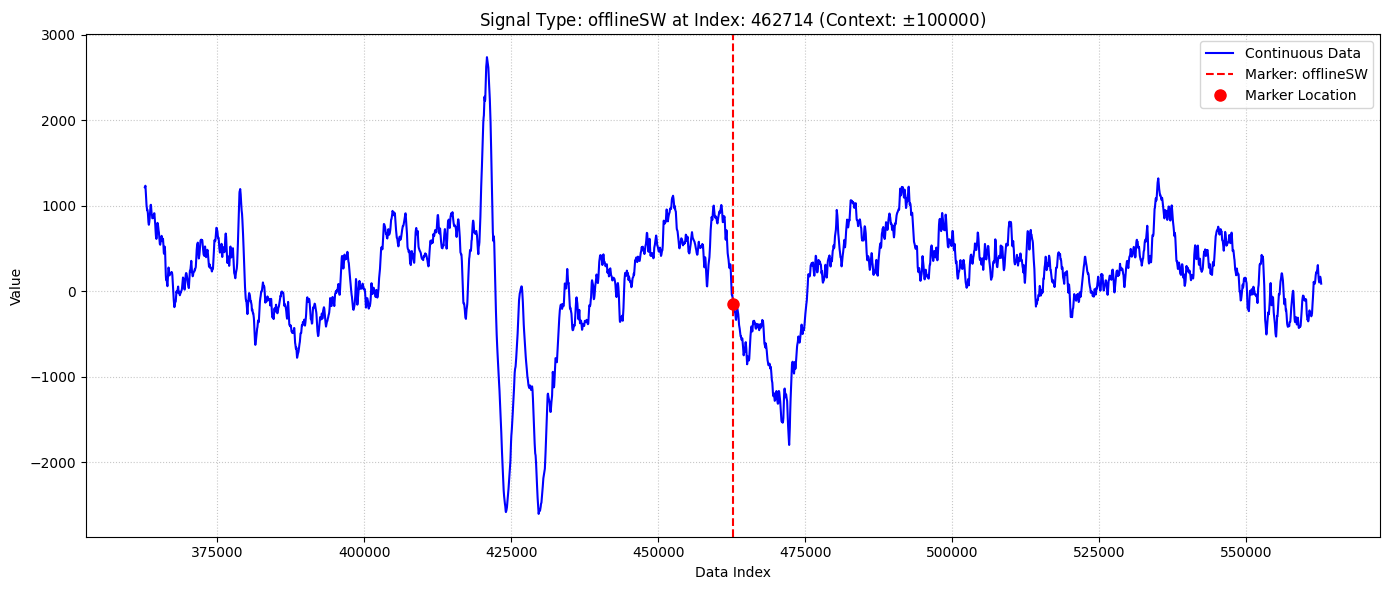

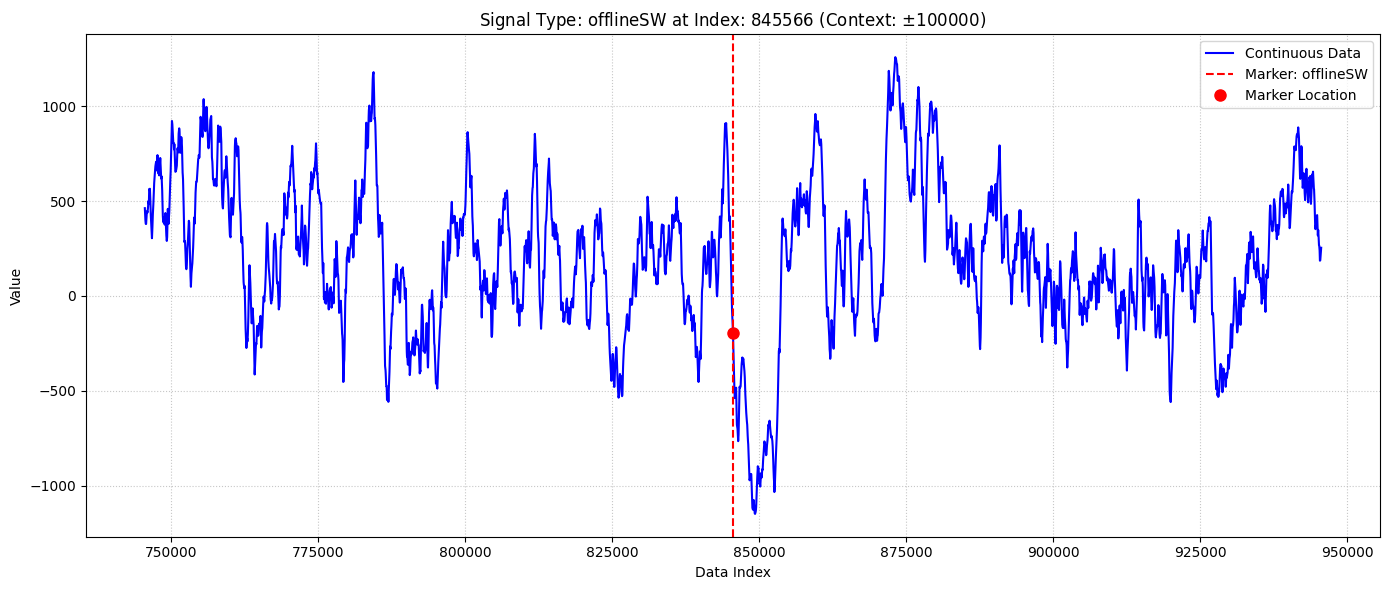

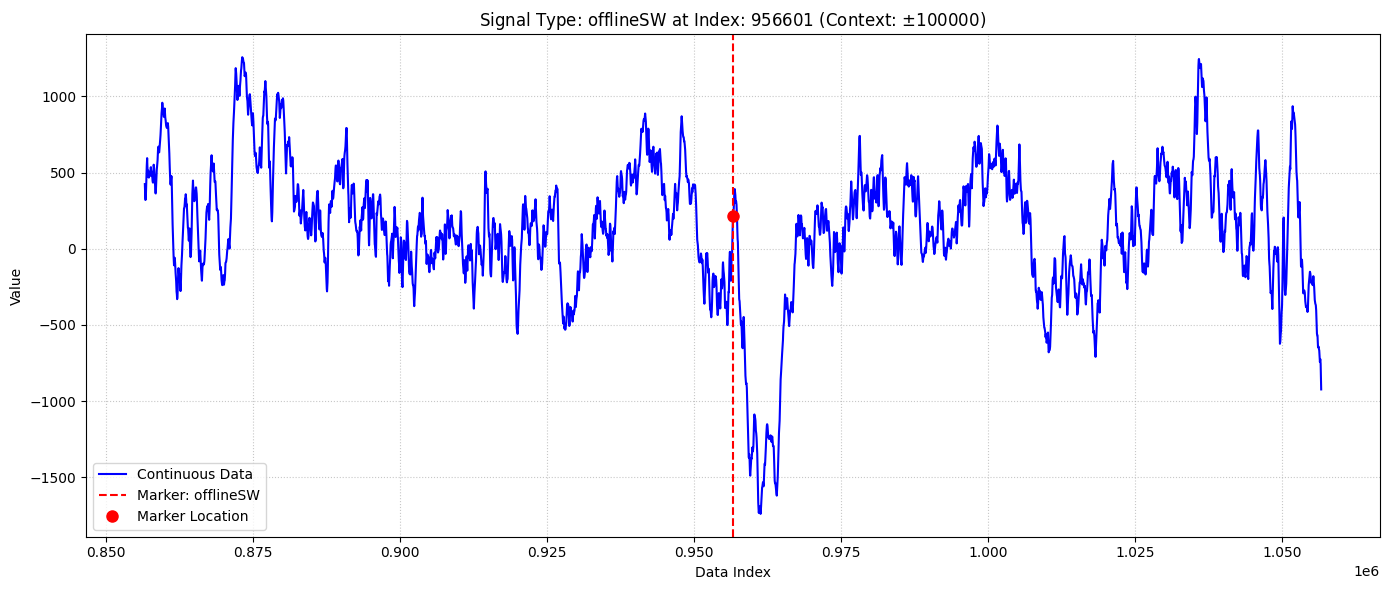


Finished displaying the first 5 marker plots.


In [6]:
# --- Main Execution ---

# 1. Parse the .mrk file
parsed_markers = parse_mrk_file_concise(mrk_file)
print("\nParsed Markers:")
for signal_type, indices in parsed_markers.items():
    print(f"  {signal_type}: {indices[:5]}... ({len(indices)} total)")

# 2. Plot each marker with context (first 10, show only)
context_window_size = 100000 # Adjust this to change how much data is shown around each marker
max_plots_to_show = 5
plots_shown_count = 0

print(f"\nGenerating and displaying the first {max_plots_to_show} plots with context window of $\pm${context_window_size}...")

# Iterate through signal types and their indices
for signal_type, indices in parsed_markers.items():
    for marker_index in indices:
        if plots_shown_count < max_plots_to_show:
            plot_marker_with_context(data, marker_index, signal_type, context_window=context_window_size)
            plots_shown_count += 1
        else:
            # Once 10 plots are shown, break out of the inner loop
            break
    if plots_shown_count >= max_plots_to_show:
        # If 10 plots are shown, break out of the outer loop too
        break

if plots_shown_count == 0:
    print("No plots were generated. Check your .mrk file or data stream.")
else:
    print(f"\nFinished displaying the first {plots_shown_count} marker plots.")

In [ ]:
#!/usr/bin/env python3
"""
DirectNeuralBiasing Python Script using YAML Configuration

This script expects a NumPy array named 'data' to be defined before 
the 'main' function is called, or for the data loading section within 
main() to be uncommented and pointed to a valid data file.
"""

import direct_neural_biasing as dnb
import numpy as np
import yaml
import os
import sys
from collections import deque

def create_config_file(config_path="config.yaml"):
    """Creates a sample YAML configuration file."""
    config = {
        'processor': {'verbose': True, 'fs': 30000.0, 'channel': 1, 'enable_debug_logging': True},
        'filters': {
            'bandpass_filters': [
                {'id': 'slow_wave_filter', 'f_low': 0.5, 'f_high': 4.0},
                {'id': 'ied_filter', 'f_low': 80.0, 'f_high': 120.0}
            ]
        },
        'detectors': {
            'wave_peak_detectors': [
                {'id': 'slow_wave_detector', 'filter_id': 'slow_wave_filter', 'z_score_threshold': 1.0, 'sinusoidness_threshold': 0.7, 'check_sinusoidness': False, 'wave_polarity': 'downwave', 'min_wave_length_ms': 500.0, 'max_wave_length_ms': 2000.0},
                {'id': 'ied_detector', 'filter_id': 'ied_filter', 'z_score_threshold': 2.5, 'sinusoidness_threshold': 0.0, 'check_sinusoidness': False, 'wave_polarity': 'upwave', 'min_wave_length_ms': None, 'max_wave_length_ms': None}
            ]
        },
        'triggers': {
            'pulse_triggers': [
                {'id': 'pulse_trigger', 'activation_detector_id': 'slow_wave_detector', 'inhibition_detector_id': 'ied_detector', 'inhibition_cooldown_ms': 1000.0, 'pulse_cooldown_ms': 0.0}
            ]
        }
    }
    with open(config_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False, indent=2)
    print(f"Created configuration file: {config_path}")

def load_data_from_file(file_path):
    """Loads data from a .csv, .npy, or .txt file."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Data file not found: {file_path}")
    
    if file_path.endswith('.csv'):
        data = np.loadtxt(file_path, delimiter=',')
    elif file_path.endswith('.npy'):
        data = np.load(file_path)
    else:
        data = np.loadtxt(file_path)
        
    print(f"Loaded {len(data)} samples from {file_path}")
    return data

def process_data_with_progress(signal_processor, data, chunk_size=4096, context_size=2000):
    """Processes data in chunks with a progress bar and gathers event context."""
    total_samples = len(data)
    if total_samples == 0:
        print("Warning: Data array is empty. Nothing to process.")
        return []
        
    total_chunks = (total_samples + chunk_size - 1) // chunk_size
    buffer_size = (context_size * 2) + 1
    event_buffer = deque(maxlen=buffer_size)
    detected_events = []
    
    signal_processor.reset_index()

    print(f"Processing {total_samples} samples in {total_chunks} chunks...")
    
    last_progress_percent = -1
    for i in range(0, total_samples, chunk_size):
        chunk = data[i:i + chunk_size].tolist()
        
        chunk_output, trigger_timestamp = signal_processor.run_chunk(chunk)
        
        for sample_result in chunk_output:
            event_buffer.append(sample_result)
            
            if len(event_buffer) == buffer_size:
                middle_sample = event_buffer[context_size]
                if middle_sample.get("triggers:pulse_trigger:triggered", 0.0) == 1.0:
                    detected_events.append({
                        'context': list(event_buffer),
                        'trigger_timestamp': trigger_timestamp,
                        'global_index': middle_sample.get("global:index", -1)
                    })
        
        # Update progress bar at 1% intervals
        current_progress = (i + chunk_size) / total_samples
        progress_percent = int(current_progress * 100)
        
        if progress_percent > last_progress_percent:
            bar_length = 50
            filled_length = int(bar_length * current_progress)
            bar = '█' * filled_length + '-' * (bar_length - filled_length)
            sys.stdout.write(f'\rProgress: |{bar}| {progress_percent}% Complete | Events: {len(detected_events)}')
            sys.stdout.flush()
            last_progress_percent = progress_percent
            
    sys.stdout.write('\n')  # Final newline after progress bar
    return detected_events

def analyze_results(events):
    """Analyzes and prints a summary of the detected events."""
    print("\n📈 ANALYSIS RESULTS:")
    print(f"Total events detected: {len(events)}")
    
    if not events:
        return

    timestamps = [e['trigger_timestamp'] for e in events if e.get('trigger_timestamp')]
    if len(timestamps) > 1:
        intervals = np.diff(timestamps)
        print(f"  - Mean interval between events: {np.mean(intervals):.3f}s (Std: {np.std(intervals):.3f}s)")

    for i, event in enumerate(events, 1):
        middle_sample = event['context'][len(event['context']) // 2]
        print(f"\nEvent {i}:")
        print(f"  - Global Index: {middle_sample.get('global:index', 'N/A')}")
        print(f"  - Raw Sample: {middle_sample.get('global:raw_sample', 'N/A'):.3f}")
        print(f"  - Slow Wave Z-Score: {middle_sample.get('detectors:slow_wave_detector:statistics:z_score', 'N/A'):.3f}")
        print(f"  - Peak Amplitude: {middle_sample.get('detectors:slow_wave_detector:peak_z_score_amplitude', 'N/A'):.3f}")

def main(data):
    """Main execution function to process data."""
    print("🧠 DirectNeuralBiasing Python Demo")
    print("=" * 50)

    config_path = "config.yaml"
    if not os.path.exists(config_path):
        print(f"Config file not found. Creating a new one...")
        create_config_file(config_path)
    else:
        print(f"Using existing config file: {config_path}")

    try:
        print(f"\n🔧 Initializing signal processor from {config_path}...")
        signal_processor = dnb.PySignalProcessor.from_config_file(config_path)
        print("✅ Signal processor initialized successfully!")

        events = process_data_with_progress(signal_processor, data, chunk_size=4096, context_size=2000)
        print("✅ Data processing completed!")

        analyze_results(events)

        print(f"\n🎉 Demo completed successfully!")

    except Exception as e:
        print(f"\n❌ An error occurred during processing: {e}")

    finally:
        # Delete config.yaml only if this script created it
        if created_config_file and os.path.exists(config_path):
            try:
                os.remove(config_path)
                print(f"\nCleaned up: Deleted {config_path}")
            except OSError as e:
                print(f"Error deleting config file {config_path}: {e}")

if __name__ == "__main__":
    # assume data is loaded in cells above
    main(data)

🧠 DirectNeuralBiasing Python Demo
Config file not found. Creating a new one...
Created configuration file: config.yaml

🔧 Initializing signal processor from config.yaml...
✅ Signal processor initialized successfully!
Processing 83220000 samples in 20318 chunks...
Progress: |█████████████████████████-------------------------| 51% Complete | Events: 144